In [ ]:
!pip install rouge-score


In [ ]:
!pip install torchmetrics


In [ ]:
import torchmetrics
print(torchmetrics.__version__)


In [ ]:
pip install --upgrade torchmetrics rouge-score


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]


✅ Performance Metrics:
🔹 BLEU Score: 0.5302
🔹 ROUGE-L Score: 0.3916
🔹 Avg Inference Time: 0.1928 sec


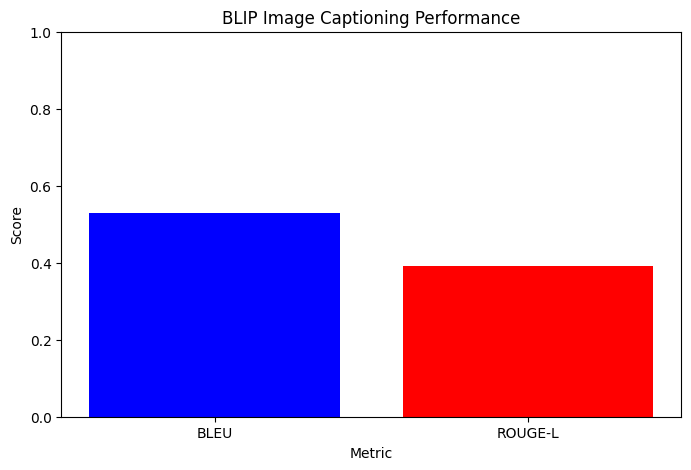

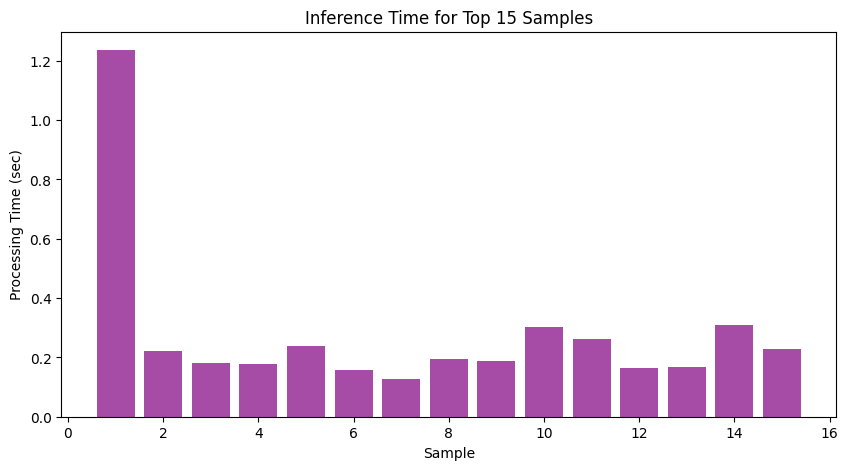

In [6]:
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BlipProcessor, BlipForConditionalGeneration
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

# Load Flickr8k Dataset
dataset = load_dataset("jxie/flickr8k", split="test")
images = dataset["image"]
references = [[dataset[f"caption_{i}"][j] for i in range(5)] for j in range(len(dataset["image"]))]

# Load BLIP Model and Processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

# Metrics Containers
predictions, ground_truths = [], []
inference_times = []
cider_scores = []
rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

# Generate Captions and Compute Metrics
for img, refs in zip(images[:100], references[:100]):
    inputs = processor(images=img, return_tensors="pt").to("cuda")
    start_time = time.time()
    output = model.generate(**inputs)
    inference_time = time.time() - start_time
    generated_caption = processor.decode(output[0], skip_special_tokens=True)
    
    predictions.append(generated_caption)
    ground_truths.append(refs)
    inference_times.append(inference_time)

# Compute Evaluation Metrics
bleu_score = corpus_bleu(ground_truths, predictions)
avg_rougeL = np.mean([rouge.score(pred, refs[0])["rougeL"].fmeasure for pred, refs in zip(predictions, ground_truths)])

# Print Results
print(f"\n✅ Performance Metrics:")
print(f"🔹 BLEU Score: {bleu_score:.4f}")
print(f"🔹 ROUGE-L Score: {avg_rougeL:.4f}")
print(f"🔹 Avg Inference Time: {np.mean(inference_times):.4f} sec")

# Plot Performance Graphs
metrics = ["BLEU", "ROUGE-L"]
scores = [bleu_score, avg_rougeL]
plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=["blue", "red"])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("BLIP Image Captioning Performance")
plt.ylim(0, 1)
plt.show()

# Plot Inference Time Analysis
plt.figure(figsize=(10, 5))
plt.bar(range(1, 16), inference_times[:15], color="purple", alpha=0.7)
plt.xlabel("Sample")
plt.ylabel("Processing Time (sec)")
plt.title("Inference Time for Top 15 Samples")
plt.show()
